In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
#from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
#from keras import initializers, regularizers, constraints, optimizers, layers
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
%matplotlib inline
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error

from keras.optimizers import Adam
from pandas import read_csv
from datetime import datetime
from pandas import read_csv
from matplotlib import pyplot

In [3]:

# load data
dataset = pd.read_csv('karl7.csv',low_memory=False, parse_dates= ['Timestamp'])
dataset = dataset.set_index('Timestamp')
dataset1 = pd.DataFrame()
'''Resample data for every 1 minute'''
dataset1['States'] = dataset['States'].resample('60s').count()
# save to file

dataset1.to_csv('data.csv')
dataset1.shape

(18761, 1)

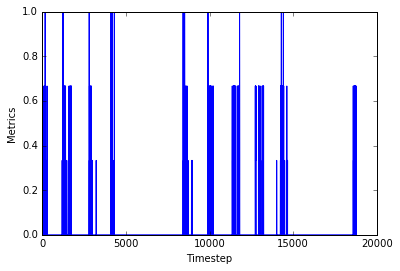

In [4]:

# load dataset
dataset = read_csv('data.csv', header=0, index_col=0)
values = dataset.values

values = values.astype('float32')

# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

# specify columns to plot

groups = [0]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(scaled[:, group])
    #pyplot.title(dataset.columns[group], y=0.5, loc='right')
    pyplot.ylabel('Metrics')
    plt.xlabel('Timestep')
    i += 1
pyplot.show()



In [6]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [13]:
n_hours = 10
n_features = 1
# frame as supervised learning
reframed = series_to_supervised(scaled, n_hours, 1)

In [16]:
# split into train and test set
values = reframed.values
n_train_hours = 11 * 24 * 60
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]
#split into input and outputs

n_obs = n_hours * n_features
train_X, train_y = train[:, :n_obs], train[:, -n_features]
test_X, test_y = test[:, :n_obs], test[:, -n_features]
print(train_X.shape, len(train_X), train_y.shape, test_X.shape, test_y.shape)

((15840, 10), 15840, (15840,), (2911, 10), (2911,))


In [17]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_hours, n_features))
test_X = test_X.reshape((test_X.shape[0], n_hours, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

((15840, 10, 1), (15840,), (2911, 10, 1), (2911,))


In [18]:
dataset = pd.read_csv('k7test.csv',low_memory=False, parse_dates= ['Timestamp'])
dataset = dataset.set_index('Timestamp')

dataset1 = pd.DataFrame()
'''Resample data for every 1 minute'''
dataset1['States'] = dataset['States'].resample('60s').count()
# save to file

dataset1.to_csv('test.csv')
# load dataset
dataset = read_csv('test.csv', header=0, index_col=0)
values = dataset.values

values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_test = scaler.fit_transform(values)

n_hours = 10
n_features = 1
# frame as supervised learning
reframed_test = series_to_supervised(scaled_test, n_hours, 1)

'''VA and T sets'''
# split into train and test set
values = reframed_test.values
n_train_hours = 12 * 24 * 60
test_set1 = values[:, :]
test_set = values[:n_train_hours, :]
Val_set = values[n_train_hours:, :]
#split into input and outputs

n_obs = n_hours * n_features
test_set1_X, test_set1_y = test_set1[:, :n_obs], test_set1[:, -n_features]
test_set_X, test_set_y = test_set[:, :n_obs], test_set[:, -n_features]
Val_set_X, Val_y = Val_set[:, :n_obs], Val_set[:, -n_features]
print(test_set_X.shape, len(test_set_X), test_set_y.shape, Val_set_X.shape, Val_y.shape)
Val_set_X = Val_set_X.reshape((Val_set_X.shape[0], n_hours, n_features))
test_set_X = test_set_X.reshape((test_set_X.shape[0], n_hours, n_features))
test_set1_X = test_set1_X.reshape((test_set1_X.shape[0], n_hours, n_features))
print(test_set_X.shape, test_set_y.shape, Val_set_X.shape, Val_y.shape, test_set1_X.shape, test_set1_y.shape)

((17280, 10), 17280, (17280,), (1471, 10), (1471,))
((17280, 10, 1), (17280,), (1471, 10, 1), (1471,), (18751, 10, 1), (18751,))


In [19]:
'''Define the model'''

model = Sequential()
model.add(LSTM(10, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(LSTM(5))
model.add(Dense(1))

'''compile the model'''
model.compile(loss= 'mse', optimizer= 'adam', metrics=['mean_squared_error'])
#model.summary()


In [20]:
'''fit the model'''
history = model.fit(train_X, train_y, validation_data=(Val_set_X, Val_y), nb_epoch=10, batch_size=32, verbose=1, shuffle=False)


Train on 15840 samples, validate on 1471 samples
Epoch 1/10
15840/15840 [==============================] - 3s - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0077 - val_mean_squared_error: 0.0077
Epoch 2/10
15840/15840 [==============================] - 3s - loss: 0.0070 - mean_squared_error: 0.0070 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 3/10
15840/15840 [==============================] - 3s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 0.0069 - val_mean_squared_error: 0.0069
Epoch 4/10
15840/15840 [==============================] - 3s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0067 - val_mean_squared_error: 0.0067
Epoch 5/10
15840/15840 [==============================] - 3s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0065 - val_mean_squared_error: 0.0065
Epoch 6/10
15840/15840 [==============================] - 3s - loss: 0.0065 - mean_squared_error: 0.0065 - val_loss: 0.0064 - val_mean_squared_error: 0.0064
Epoch 7/1

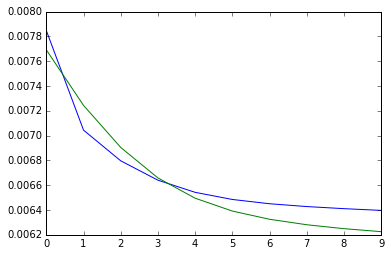

In [21]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')

In [22]:
# make a prediction
yhat = model.predict(train_X)
print(yhat.shape,test_y.shape, test_X.shape)

((15840, 1), (2911,), (2911, 10, 1))


In [23]:
test_X = train_X
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
print(test_X.shape)

(15840, 10)


In [24]:
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
print(inv_yhat.shape)

(15840,)


In [25]:

# invert scaling for actual

test_y = train_y.reshape((len(train_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
print(inv_y.shape)

(15840,)


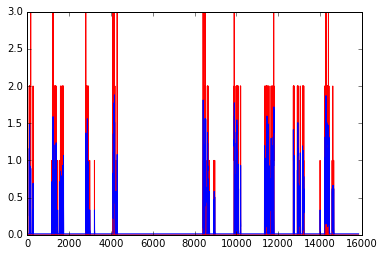

In [27]:
e = inv_y  - inv_yhat
pyplot.plot(inv_y, color='red')

pyplot.plot(inv_yhat, color='blue')


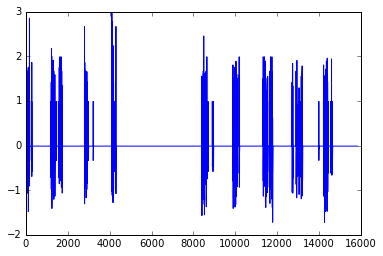

In [28]:
pyplot.plot(e, color='blue')

In [29]:
from scipy.stats import norm

parameters = norm.fit(e)
print(parameters[0], parameters[1])



(-0.011973401073143123, 0.23900520185782)


In [30]:
# make a prediction
Val_set_X = test_set1_X
vhat = model.predict(Val_set_X)
Val_set_X = Val_set_X.reshape((Val_set_X.shape[0], n_hours*n_features))
inv_vhat = np.concatenate((vhat, Val_set_X[:, -1:]), axis=1)
inv_vhat = scaler.inverse_transform(inv_vhat)
inv_vhat = inv_vhat[:,0]
Val_y = test_set1_y
# invert scaling for actual
Val_y = Val_y.reshape((len(Val_y), 1))
inv_v = np.concatenate((Val_y, Val_set_X[:, -1:]), axis=1)
inv_v = scaler.inverse_transform(inv_v)
inv_v = inv_v[:,0]
x = inv_v  - inv_vhat

x

array([ 0.41749347,  0.2828227 , -0.84905234, ...,  0.8422704 ,
       -0.42561327,  0.6594275 ])

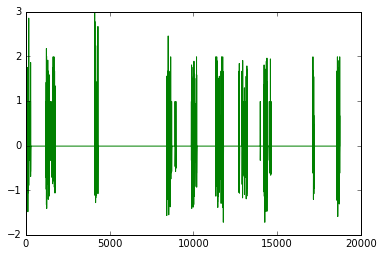

In [31]:
pyplot.plot(x, color='green')

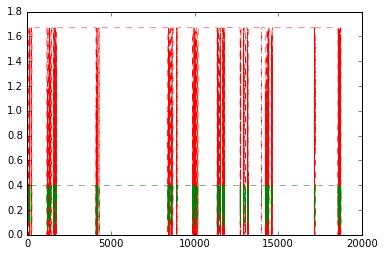

In [37]:
fitted_pdf = norm.pdf(x,loc = parameters[0],scale = parameters[1])
normal_pdf = norm.pdf(x)
plt.plot(fitted_pdf,"red",linestyle="dashed", linewidth=0.5)
#plt.plot(inv_v,"blue",linestyle="dashed", linewidth=0.5)
#plt.plot(inv_vhat,"yellow",linestyle="dashed", linewidth=0.5)
#plt.plot(scaled,"green",linestyle="dashed", linewidth=0.5)
#plt.plot(e,"red",linestyle="dashed", linewidth=0.5)
plt.plot(normal_pdf,"green",linestyle="dashed", linewidth=0.5)
# insert a legend in the plot (using label)
plt.legend()

# we finally show our work
plt.show()

In [ ]:
'''Evaluate the model'''
loss = model.evaluate(test_X, test_y, verbose=2)
#print( 'MSE: %f' % loss)
loss

In [ ]:
'''Predictions'''

for i in range(len(train_X)):
    train_y_pred = model.predict(train_X)
    print( 'expected: %f' % train_y)
    print( 'predicted: %f' % train_y_pred)
    
 
#predictions1 = model.predict(test_X)

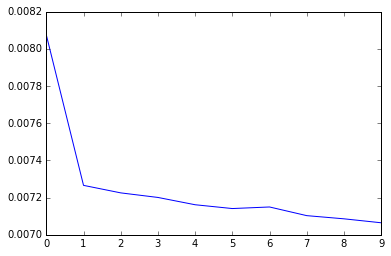

In [16]:

'''predictor Error'''
pyplot.plot(history.history['mean_squared_error'])
#errors = train_y - predictions

#print(errors)

In [ ]:


'''Plot history'''

#pyplot.plot(errors)

#pyplot.plot(history.history['loss'], label='train')
#pyplot.plot(history.history['val_loss'], label='test')

Train on 15840 samples, validate on 2920 samples
Epoch 1/10
0s - loss: 0.0087 - mean_squared_error: 0.0087 - mean_absolute_error: 0.0354 - val_loss: 0.0037 - val_mean_squared_error: 0.0037 - val_mean_absolute_error: 0.0280
Epoch 2/10
0s - loss: 0.0074 - mean_squared_error: 0.0074 - mean_absolute_error: 0.0297 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0215
Epoch 3/10
0s - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0281 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0200
Epoch 4/10
0s - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0280 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0196
Epoch 5/10
0s - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 0.0279 - val_loss: 0.0034 - val_mean_squared_error: 0.0034 - val_mean_absolute_error: 0.0194
Epoch 6/10
0s - loss: 0.0073 - mean_squared_error: 0.0073 - mean_absolute_error: 

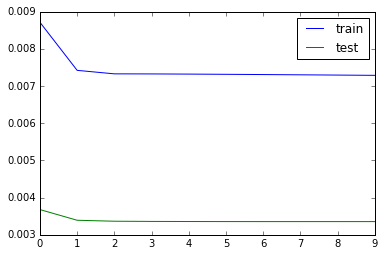

In [26]:
# design network
model = Sequential()
model.add(LSTM(60, input_shape=(train_X.shape[1], train_X.shape[2])))
#model.add(LSTM(60, stateful=True, batch_input_shape=(1,train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
#model.compile(loss='mae', optimizer='adam')
model.compile(loss='mse', optimizer='adam', metrics=['mean_squared_error', 'mean_absolute_error'])
# fit network
history = model.fit(train_X, train_y,batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
#pyplot.plot(history.history['mean_squared_error'])
#pyplot.plot(history.history['val_mean_absolute_error'])
pyplot.legend()
pyplot.show()

In [41]:
print(model.summary())

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lstm_2 (LSTM)                    (None, 60)            14880       lstm_input_2[0][0]               
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1)             61          lstm_2[0][0]                     
Total params: 14941
____________________________________________________________________________________________________
None


In [42]:
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], test_X.shape[2]))
# invert scaling for forecast
inv_yhat = np.concatenate((yhat, test_X[:, 1:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, 1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.174


In [18]:
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma
means, covs = list(),list()
mean, cov = estimateGaussian(dataset)

def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

def selectThresholdByCV(probs,gt):
    best_epsilon = 0
    best_f1 = 0
    f = 0
    stepsize = (max(probs) - min(probs)) / 1000;
    epsilons = np.arange(min(probs),max(probs),stepsize)
    for epsilon in np.nditer(epsilons):
        predictions = (probs < epsilon)
        f = f1_score(gt, predictions, average = "binary")
        if f > best_f1:
            best_f1 = f
            best_epsilon = epsilon
    return best_f1, best_epsilon

[array(79.16616105)]

In [14]:
from torch.autograd import Variable
import torch
import numpy as np

def fit_norm_distribution_param(args, model, train_dataset, channel_idx=0):
    predictions = []
    organized = []
    errors = []
    with torch.no_grad():
        # Turn on evaluation mode which disables dropout.
        model.eval()
        pasthidden = model.init_hidden(1)
        for t in range(len(train_dataset)):
            out, hidden = model.forward(train_dataset[t].unsqueeze(0), pasthidden)
            predictions.append([])
            organized.append([])
            errors.append([])
            predictions[t].append(out.data.cpu()[0][0][channel_idx])
            pasthidden = model.repackage_hidden(hidden)
            for prediction_step in range(1,args.prediction_window_size):
                out, hidden = model.forward(out, hidden)
                predictions[t].append(out.data.cpu()[0][0][channel_idx])

            if t >= args.prediction_window_size:
                for step in range(args.prediction_window_size):
                    organized[t].append(predictions[step+t-args.prediction_window_size][args.prediction_window_size-1-step])
                organized[t]= torch.FloatTensor(organized[t]).to(args.device)
                errors[t] = organized[t] - train_dataset[t][0][channel_idx]
                errors[t] = errors[t].unsqueeze(0)

    errors_tensor = torch.cat(errors[args.prediction_window_size:],dim=0)
    mean = errors_tensor.mean(dim=0)
    cov = errors_tensor.t().mm(errors_tensor)/errors_tensor.size(0) - mean.unsqueeze(1).mm(mean.unsqueeze(0))
    # cov: positive-semidefinite and symmetric.
    return mean, cov

In [16]:
means, covs = list(),list()
mean, cov = fit_norm_distribution_param(args, model, train_X, channel_idx=0)
means.append(mean), covs.append(cov)

NameError: name 'args' is not defined

In [45]:
from pandas import Series
series = Series.from_csv('orders11a.csv', header=0)
series = Series(series)
#print(series)


In [17]:
from pandas import read_csv
series = read_csv('orders11a.csv', header=0, parse_dates=[1], index_col=0, squeeze=True)
print(type(series))
print(series.head())
print(series.size)

<class 'pandas.core.series.Series'>
States
2312   2018-03-08 17:31:23
3313   2018-03-08 17:31:24
4314   2018-03-08 17:31:25
5315   2018-03-08 17:31:26
6316   2018-03-08 17:31:27
Name: Timestamp, dtype: datetime64[ns]
8627


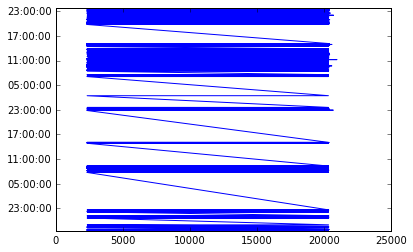

In [24]:
from matplotlib import pyplot
%matplotlib inline
pyplot.plot(series)
pyplot.show()

In [25]:
from numpy import array
data = array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
data = data.reshape((1, 10, 1))
print(data.shape)

(1, 10, 1)


In [26]:
from numpy import array
data = array([
	[0.1, 1.0],
	[0.2, 0.9],
	[0.3, 0.8],
	[0.4, 0.7],
	[0.5, 0.6],
	[0.6, 0.5],
	[0.7, 0.4],
	[0.8, 0.3],
	[0.9, 0.2],
	[1.0, 0.1]])
data = data.reshape(1, 10, 2)
print(data.shape)



(1, 10, 2)


In [30]:
# define contrived series
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
series = Series(data)
print(series)
# prepare data for normalization
values = series.values
values = values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
#print( ✬ Min: %f, Max: %f ✬ % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print
normalized = scaler.transform(values)
print(normalized)
# inverse transform and print
inversed = scaler.inverse_transform(normalized)
print(inversed)

0     10.0
1     20.0
2     30.0
3     40.0
4     50.0
5     60.0
6     70.0
7     80.0
8     90.0
9    100.0
dtype: float64
[[ 0.        ]
 [ 0.11111111]
 [ 0.22222222]
 [ 0.33333333]
 [ 0.44444444]
 [ 0.55555556]
 [ 0.66666667]
 [ 0.77777778]
 [ 0.88888889]
 [ 1.        ]]
[[  10.]
 [  20.]
 [  30.]
 [  40.]
 [  50.]
 [  60.]
 [  70.]
 [  80.]
 [  90.]
 [ 100.]]
